# **Forecasting**

**Forecasting** adalah metode membuat prediksi informasi dengan menggunakan data historis sebagai input utama untuk menentukan arah tren masa depan.

#### **Mengapa Forecasting penting?**

Pada intinya, kita melihat pola-pola yang terjadi di masa lalu (seperti tren musiman, siklus, atau kebiasaan) dan menggunakan pola tersebut untuk membuat perkiraan yang logis tentang apa yang akan terjadi selanjutnya.Tujuan utamanya adalah untuk mengurangi ketidakpastian dalam pengambilan keputusan. Dengan memiliki perkiraan yang berbasis data, sebuah organisasi atau individu dapat membuat perencanaan yang lebih matang, mengantisipasi risiko, dan mengalokasikan sumber daya secara lebih efisien.

## **Businness Understanding**


**1. Latar Belakang**

Kualitas udara merupakan salah satu faktor penting yang memengaruhi kesehatan masyarakat, produktivitas, serta keberlanjutan lingkungan. Salah satu indikator utama dalam pengukuran kualitas udara adalah konsentrasi gas Nitrogen Dioksida (NO₂).

Gas NO₂ banyak dihasilkan dari:

* Aktivitas transportasi (emisi kendaraan bermotor),

* Industri pembakaran bahan bakar fosil,

* Serta proses kimia di atmosfer.

Tingginya kadar NO₂ dapat menyebabkan berbagai dampak negatif, seperti:

* Meningkatkan risiko penyakit pernapasan,

* Menurunkan kualitas udara ambien,

* Memengaruhi ekosistem dan produktivitas tanaman.


**2. Tujuan Bisins**

Membangun model prediksi (forecasting) konsentrasi NO₂ harian berdasarkan data pengamatan beberapa hari sebelumnya.
Dengan model ini, diharapkan:

1. Pemantauan kualitas udara menjadi lebih proaktif.

2. Peringatan dini (early warning system) dapat diberikan ketika polutan diprediksi meningkat.

3. Pengambilan keputusan berbasis data (data-driven decision making) untuk kebijakan lingkungan menjadi lebih tepat waktu.
4. Perencanaan kebijakan kota seperti pembatasan kendaraan, jadwal industri, atau kegiatan luar ruangan bisa dioptimalkan.



In [ ]:
!pip install openeo

## **Instalasi Library**

In [ ]:
import openeo
import pandas as pd
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

## **Data Understanfing**



### **Pengumpulan Data**

**Sumber Data**

Data yang digunakan dalam penelitian ini diperoleh dari:

1. Platform: Copernicus Data Space Ecosystem (CDSE)

1. Koleksi Data: Sentinel-5P Level 2

1. Variabel yang diambil: Konsentrasi Nitrogen Dioksida (NO₂)

1. Area of Interest (AOI): Wilayah Gresik dan sekitarnya di Jawa Timur, Indonesia

1. Periode Pengamatan: 30 hari (20 September 2025 – 20 Oktober 2025)

Data spasial AOI diperoleh menggunakan geojson.io
, yaitu platform berbasis web yang digunakan untuk menggambar batas wilayah dan mengekspor koordinat dalam format GeoJSON.

#### **Koneksi Platform CDSE**

In [ ]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


Kode ini berfungsi untuk membuat koneksi antara Python dengan Copernicus Data Space Ecosystem (CDSE) menggunakan OpenEO API dan melakukan autentikasi (login) ke akun kita

#### **Pengambilan Data dari Koordinat Gresik**

Data *NO2* dIambil dari area Gresik dengan rentang 30 hari

In [ ]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [
              112.45971691333881,
              -7.051386818809732
            ],
            [
              112.45971691333881,
              -7.307257822416759
            ],
            [
              112.65723691937552,
              -7.307257822416759
            ],
            [
              112.65723691937552,
              -7.051386818809732
            ],
            [
              112.45971691333881,
              -7.051386818809732
            ]
        ]
    ],
}

s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 112.45971691333881,
        "south": -7.307257822416759,
        "east": 112.65723691937552,
        "north": -7.051386818809732,
    },
    temporal_extent=["2025-09-20", "2025-10-20"],
    bands=["NO2"],
)

def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

job = daily_mean_aoi.execute_batch(out_format="CSV")

results = job.get_results()
results.download_files("data-copernicus")

for f in os.listdir("data-copernicus"):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join("data-copernicus", f))
        print("File ditemukan:", f)
        break

df["date"] = pd.to_datetime(df["date"])

df["month"] = df["date"].dt.to_period("M")

df_monthly = df.groupby("month", as_index=False)["NO2"].mean()
df

0:00:00 Job 'j-2511021155314e62ad928f80f90cc344': send 'start'
0:00:13 Job 'j-2511021155314e62ad928f80f90cc344': created (progress 0%)
0:00:19 Job 'j-2511021155314e62ad928f80f90cc344': created (progress 0%)
0:00:25 Job 'j-2511021155314e62ad928f80f90cc344': created (progress 0%)
0:00:33 Job 'j-2511021155314e62ad928f80f90cc344': created (progress 0%)
0:00:43 Job 'j-2511021155314e62ad928f80f90cc344': running (progress N/A)
0:00:56 Job 'j-2511021155314e62ad928f80f90cc344': running (progress N/A)
0:01:11 Job 'j-2511021155314e62ad928f80f90cc344': running (progress N/A)
0:01:31 Job 'j-2511021155314e62ad928f80f90cc344': running (progress N/A)
0:01:55 Job 'j-2511021155314e62ad928f80f90cc344': finished (progress 100%)
File ditemukan: timeseries.csv


/tmp/ipython-input-3702221239.py:63: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


,date,feature_index,NO2,month
0,2025-09-25 00:00:00+00:00,0,0.000087,2025-09
1,2025-09-27 00:00:00+00:00,0,0.000039,2025-09
2,2025-09-23 00:00:00+00:00,0,0.000158,2025-09
3,2025-09-24 00:00:00+00:00,0,0.000261,2025-09
4,2025-09-21 00:00:00+00:00,0,0.000063,2025-09
5,2025-09-22 00:00:00+00:00,0,0.000066,2025-09
6,2025-09-28 00:00:00+00:00,0,0.000032,2025-09
7,2025-09-26 00:00:00+00:00,0,0.000056,2025-09
8,2025-10-11 00:00:00+00:00,0,0.000065,2025-10
9,2025-10-12 00:00:00+00:00,0,0.000023,2025-10


Pertama, mendefinisikan wilayah pengamatan (AOI) berupa area Gresik dan sekitarnya dalam format koordinat GeoJSON. Setelah itu, sistem memanggil koleksi data SENTINEL_5P_L2 untuk rentang waktu 20 September hingga 20 Oktober 2025 dan memilih band NO₂. Nilai yang tidak valid (negatif) dihapus, kemudian data diolah menjadi rata-rata harian dan rata-rata spasial di dalam area tersebut.

In [ ]:
new_df = pd.read_csv('data-copernicus/timeseries.csv')
new_df = new_df.sort_values(by='date').reset_index(drop=True)
new_df['date'] = pd.to_datetime(new_df['date']).dt.date
new_df

,date,feature_index,NO2
0,2025-09-19,0,NaN
1,2025-09-20,0,0.000104
2,2025-09-21,0,0.000063
3,2025-09-22,0,0.000066
4,2025-09-23,0,0.000158
5,2025-09-24,0,0.000261
6,2025-09-25,0,0.000087
7,2025-09-26,0,0.000056
8,2025-09-27,0,0.000039
9,2025-09-28,0,0.000032


### **Eksplorasi Data**

#### **Cek Missing Value**

/tmp/ipython-input-3737469000.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, v + 0.5, f"{v} ({missing_percent[i]:.1f}%)",


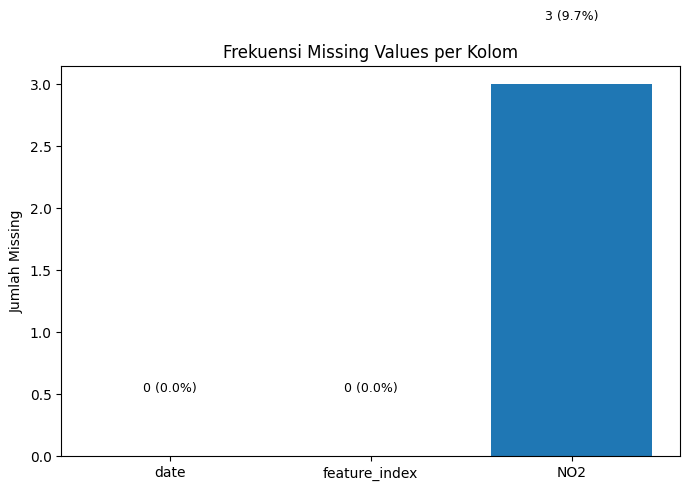

,Missing Count,Missing Percent (%)
date,0,0.00
feature_index,0,0.00
NO2,3,9.68


In [ ]:
missing_count = new_df.isnull().sum()
missing_percent = (missing_count / len(df)) * 100

fig, ax = plt.subplots(figsize=(7,5))

bars = ax.bar(missing_count.index, missing_count)

ax.set_title("Frekuensi Missing Values per Kolom")
ax.set_ylabel("Jumlah Missing")

for i, v in enumerate(missing_count):
    ax.text(i, v + 0.5, f"{v} ({missing_percent[i]:.1f}%)",
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

Terlihat pada data yang sudah didapatkan, terdapat 3 missing value

#### **Statistik Data**

In [ ]:
desc = new_df.describe()
desc

,feature_index,NO2
count,31.0,28.000000
mean,0.0,0.000078
std,0.0,0.000050
min,0.0,0.000019
25%,0.0,0.000050
50%,0.0,0.000064
75%,0.0,0.000091
max,0.0,0.000261


* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).
* Jumlah data yang valid (ada 31 hari pengamatan).

## **Prepocessing Data**

### **Penanganan Missing Value**

Missing value pada data NO₂ ditangani menggunakan metode interpolasi linier dan pengisian berantai (backward dan forward fill).

Pertama, dilakukan interpolasi linier untuk memperkirakan nilai yang hilang di antara dua data yang masih valid berdasarkan kecenderungan garis lurus. Langkah ini menjaga kontinuitas perubahan nilai harian tanpa mengubah pola tren aslinya.

Setelah itu, jika masih terdapat nilai kosong di awal atau akhir data, dilakukan pengisian nilai terdekat menggunakan metode backward fill (mengisi dengan nilai setelahnya) dan forward fill (mengisi dengan nilai sebelumnya).

In [ ]:
new_df['NO2'] = new_df['NO2'].interpolate(method='linear')
new_df['NO2'] = new_df['NO2'].fillna(method='bfill').fillna(method='ffill')



/tmp/ipython-input-3842364359.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df['NO2'] = new_df['NO2'].fillna(method='bfill').fillna(method='ffill')


Tampilkan Data

In [ ]:
info_table = pd.DataFrame({
    "Kolom": new_df.columns,
    "Tipe Data": new_df.dtypes.astype(str),
    "Jumlah Data Tidak Kosong": len(new_df) - new_df.isna().sum(),
    "Jumlah Missing": new_df.isna().sum()
})
info_table

,Kolom,Tipe Data,Jumlah Data Tidak Kosong,Jumlah Missing
date,date,object,31,0
feature_index,feature_index,int64,31,0
NO2,NO2,float64,31,0


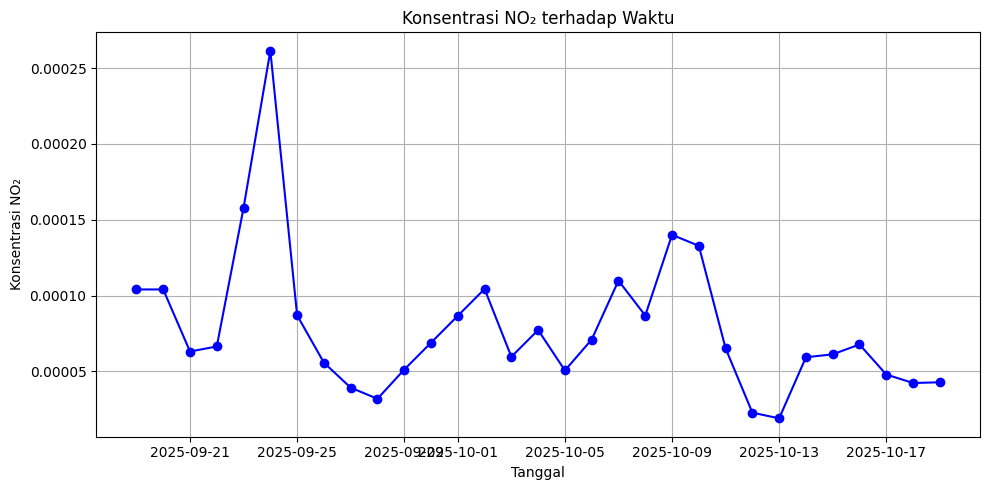

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(new_df['date'], new_df['NO2'], marker='o', linestyle='-', color='blue')
plt.title("Konsentrasi NO₂ terhadap Waktu")
plt.xlabel("Tanggal")
plt.ylabel("Konsentrasi NO₂")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Revisi**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import pandas as pd

# === 1️⃣ Pisahkan fitur dan target ===
# Pastikan hanya kolom numerik yang dipakai
X = new_df.drop(columns=['NO2', 'date', 'month'], errors='ignore')
y = new_df['NO2']

# === 2️⃣ Split Train-Test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === 3️⃣ Normalisasi (Min-Max hanya dari TRAIN) ===
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit hanya dari data TRAIN
X_train_scaled = scaler_X.fit_transform(X_train.select_dtypes(include='number'))
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# Transform TEST berdasarkan skala TRAIN
X_test_scaled = scaler_X.transform(X_test.select_dtypes(include='number'))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# === 4️⃣ Modeling (KNN Regression) ===
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train_scaled.ravel())

# === 5️⃣ Prediksi TRAIN & TEST ===
y_train_pred_scaled = knn.predict(X_train_scaled)
y_test_pred_scaled = knn.predict(X_test_scaled)

# === 6️⃣ Denormalisasi hasil prediksi ===
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1))

# === 7️⃣ Evaluasi Performansi ===
mape_train = mean_absolute_percentage_error(y_train, y_train_pred) * 100

mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100

# === 8️⃣ Cetak hasil ===
print("📊 HASIL TRAIN:")
print(f"MAPE : {mape_train:.2f}%")

print("\n📈 HASIL TEST MAPE:")
print(f"MAPE : {mape_test:.2f}%")


📊 HASIL TRAIN:
MAPE : 50.01%

📈 HASIL TEST MAPE:
MAPE : 98.50%


/tmp/ipython-input-3926600277.py:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


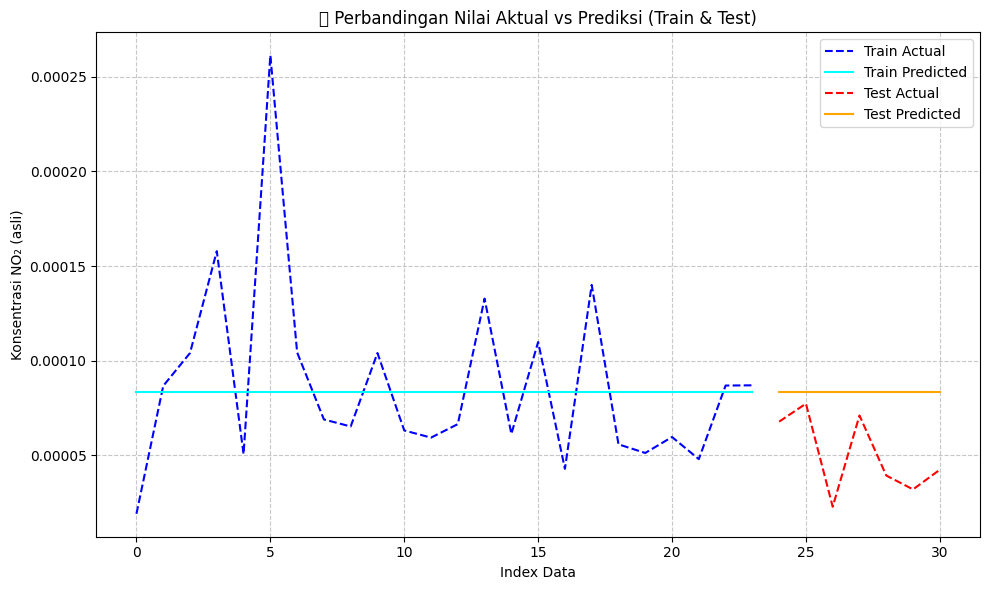

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Siapkan data untuk plotting ---
# Ambil sebagian kecil data agar grafik tidak terlalu padat
n_show_train = min(len(y_train), 100)  # misalnya tampilkan 100 data pertama
n_show_test = min(len(y_test), 100)

# Konversi ke array agar index rapi
y_train_actual = np.array(y_train)[:n_show_train]
y_train_pred_plot = y_train_pred[:n_show_train]

y_test_actual = np.array(y_test)[:n_show_test]
y_test_pred_plot = y_test_pred[:n_show_test]

# --- Plot ---
plt.figure(figsize=(10, 6))

# Train set
plt.plot(y_train_actual, label='Train Actual', color='blue', linestyle='--')
plt.plot(y_train_pred_plot, label='Train Predicted', color='cyan')

# Test set
plt.plot(
    range(len(y_train_actual), len(y_train_actual) + len(y_test_actual)),
    y_test_actual, label='Test Actual', color='red', linestyle='--'
)
plt.plot(
    range(len(y_train_actual), len(y_train_actual) + len(y_test_pred_plot)),
    y_test_pred_plot, label='Test Predicted', color='orange'
)

# --- Gaya plot ---
plt.title("📈 Perbandingan Nilai Aktual vs Prediksi (Train & Test)")
plt.xlabel("Index Data")
plt.ylabel("Konsentrasi NO₂ (asli)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Grafik yang kamu tampilkan menunjukkan perubahan konsentrasi gas *NO₂* (Nitrogen Dioksida) terhadap waktu di wilayah **Gresik** selama periode **20 September – 20 Oktober 2025.**

### Hasil Grafik

1. Fluktuasi yang jelas antar hari
Terlihat bahwa kadar NO₂ naik-turun cukup tajam, menandakan bahwa polusi udara di wilayah Gresik berubah secara signifikan dari hari ke hari — kemungkinan dipengaruhi oleh faktor cuaca (hujan, arah angin) atau aktivitas industri.

1. Puncak tertinggi sekitar 24–25 September 2025
Nilai NO₂ mencapai puncaknya (sekitar 0.00025 mol/m²) pada tanggal tersebut.
Ini bisa menandakan:

    * Aktivitas industri atau lalu lintas yang meningkat, atau

    * Kondisi atmosfer (misalnya cuaca stabil tanpa hujan) yang menyebabkan akumulasi polutan.

3. Penurunan tajam setelah puncak
Setelah tanggal 25 September, kadar NO₂ turun drastis — kemungkinan karena curah hujan atau angin kuat yang menyebarkan polutan.

4. Periode stabil di awal Oktober
Sekitar 1–10 Oktober terlihat fluktuasi ringan dengan pola relatif stabil di kisaran 0.00005 – 0.00015 mol/m².
Ini menandakan udara lebih bersih dibandingkan akhir September.

5. Fluktuasi kecil di pertengahan Oktober
Menjelang pertengahan bulan (10–17 Oktober), konsentrasi NO₂ sedikit meningkat lalu turun kembali, menandakan aktivitas polutan yang sedang-sedang saja.

## **Pengubahan Data Menjadi Supervised Learning**

Karena model hanya butuh nilai angka (NO2) tanpa informasi tanggal, kolom date dihapus agar dataset berisi nilai konsentrasi saja.

langkah ini dilakukan dengan menggeser (lagging) data historis untuk membuat hubungan antara nilai-nilai masa lalu dan nilai masa kini. Artinya, kita mengubah satu kolom data deret waktu — misalnya kolom NO2 — menjadi format input-output.

Dalam bentuk sederhananya:

Nilai-nilai dari beberapa hari sebelumnya (t-1, t-2, t-3, dst.) dijadikan sebagai fitur (X)

Nilai hari ini (t) dijadikan sebagai target (y) yang akan diprediksi

In [ ]:
day2 = new_df
day3 = new_df
day4 = new_df
day5 = new_df

In [ ]:
# === Membuat fungsi otomatis untuk membentuk dataset supervised ===
def make_supervised(df, n_lag):
    data = df.copy()
    data = data.drop(columns=['date'], errors='ignore')

    # Buat kolom lag (t-1, t-2, dst)
    for i in range(1, n_lag + 1):
        data[f"t{i}"] = data['NO2'].shift(i)

    # Tambahkan target untuk prediksi hari esok (t+1)
    data['target'] = data['NO2'].shift(-1)

    # Hapus baris yang mengandung NaN (karena efek shift)
    data = data.dropna().reset_index(drop=True)
    return data


# === Buat day2, day3, day4, day5 ===
day2 = make_supervised(new_df, 2)
day3 = make_supervised(new_df, 3)
day4 = make_supervised(new_df, 4)
day5 = make_supervised(new_df, 5)

day5


,feature_index,NO2,t1,t2,t3,t4,t5,target
0,0,0.000261,0.000158,0.000066,0.000063,0.000104,0.000104,0.000087
1,0,0.000087,0.000261,0.000158,0.000066,0.000063,0.000104,0.000056
2,0,0.000056,0.000087,0.000261,0.000158,0.000066,0.000063,0.000039
3,0,0.000039,0.000056,0.000087,0.000261,0.000158,0.000066,0.000032
4,0,0.000032,0.000039,0.000056,0.000087,0.000261,0.000158,0.000051
5,0,0.000051,0.000032,0.000039,0.000056,0.000087,0.000261,0.000069
6,0,0.000069,0.000051,0.000032,0.000039,0.000056,0.000087,0.000087
7,0,0.000087,0.000069,0.000051,0.000032,0.000039,0.000056,0.000104
8,0,0.000104,0.000087,0.000069,0.000051,0.000032,0.000039,0.000060
9,0,0.000060,0.000104,0.000087,0.000069,0.000051,0.000032,0.000077


## **Modelling**

modelling dilakukan untuk memprediksi kadar gas Nitrogen Dioksida (NO₂) di wilayah Gresik berdasarkan data 30 hari hasil pengamatan satelit Sentinel-5P.
Tujuan utamanya adalah melihat apakah data kadar NO₂ beberapa hari sebelumnya dapat digunakan untuk memperkirakan kadar NO₂ hari berikutnya.

Model yang digunakan adalah algoritma Random Forest Regressor.

### **Tujuan Modelling Lag n Day**

Untuk mengetahui berapa hari sebelumnya (lag) yang paling berpengaruh dalam memprediksi kadar NO₂ hari ini, dibuat beberapa model dengan variasi jumlah hari sebelumnya:

* Lag 2 Hari (day2) → menggunakan data 2 hari terakhir untuk memprediksi hari ke-3

* Lag 3 Hari (day3) → menggunakan data 3 hari terakhir untuk memprediksi hari ke-4

* Lag 4 Hari (day4) → menggunakan data 4 hari terakhir untuk memprediksi hari ke-5

* Lag 5 Hari (day5) → menggunakan data 5 hari terakhir untuk memprediksi hari ke-6

Setiap model dievaluasi menggunakan dua metrik:

* Mean Squared Error (MSE) → mengukur rata-rata kesalahan prediksi.

* R² (R-squared) → menunjukkan seberapa baik model menjelaskan variasi data aktual.

### **Modeling Forecasting dengan Lag 2 Hari**

In [ ]:
X = day2.drop(columns=['NO2'])
y = day2['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
day2_predict = knn.predict(X_test_scaled)
r2_day2 = r2_score(y_test, day2_predict)
mse_day2 = mean_squared_error(y_test, day2_predict)

print("MSE:", mse_day2)
print("R2:", r2_day2)

MSE: 4.683684724949358e-10
R2: -0.8800198781165256


### **Modeling Forecasting dengan Lag 3 Hari**

In [ ]:
X = day3.drop(columns=['NO2'])
y = day3['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
day3_predict = knn.predict(X_test_scaled)
r2_day3 = r2_score(y_test, day3_predict)
mse_day3 = mean_squared_error(y_test, day3_predict)

print("MSE:", mse_day3)
print("R2:", r2_day3)

MSE: 7.989080895149129e-10
R2: -0.8550321650965449


### **Modeling Forecasting dengan Lag 4 Hari**

In [ ]:
X = day4.drop(columns=['NO2'])
y = day4['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
day4_predict = knn.predict(X_test_scaled)
r2_day4 = r2_score(y_test, day4_predict)
mse_day4 = mean_squared_error(y_test, day4_predict)

print("MSE:", mse_day4)
print("R2:", r2_day4)

MSE: 1.189103228437246e-09
R2: 0.14490305168600381


### **Modeling Forecasting dengan Lag 5 Hari**

In [ ]:
X = day5.drop(columns=['NO2'])
y = day5['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
day5_predict = knn.predict(X_test_scaled)
r2_day5 = r2_score(y_test, day5_predict)
mse_day5 = mean_squared_error(y_test, day5_predict)

print("MSE:", mse_day5)
print("R2:", r2_day5)

MSE: 6.882919004378688e-09
R2: -0.13127534167811938


## **Perbandingan Performa Model (Nilai R² Tiap Lag Hari)**

* Variabel x berisi label jumlah hari sebelumnya (2, 3, 4, dan 5 hari).

* Variabel y berisi nilai R² dari masing-masing model (hasil evaluasi).

* Kemudian dibuat grafik batang (bar chart) untuk memvisualisasikan perbandingan nilai R² antar model.

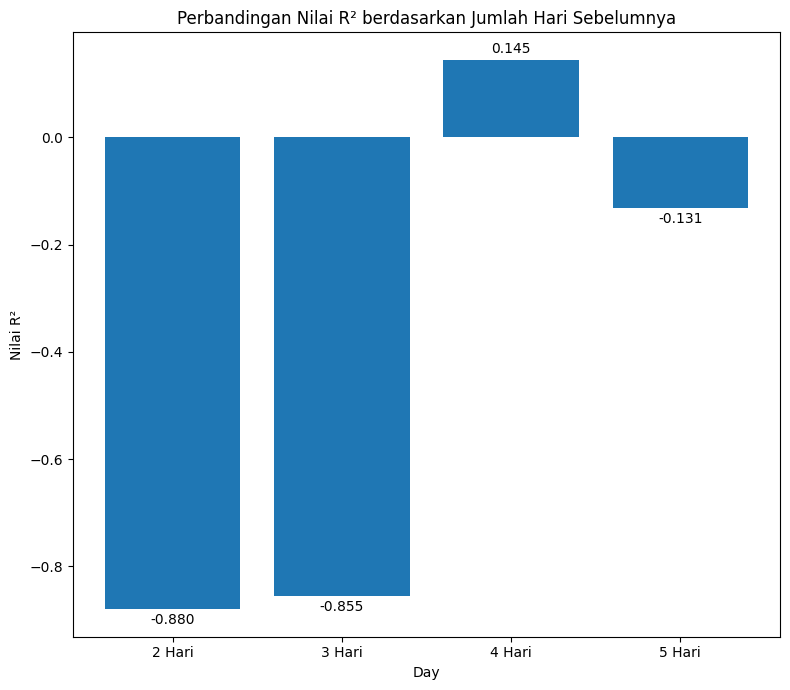

In [ ]:
x = ['2 Hari', '3 Hari', '4 Hari', '5 Hari']
y = [r2_day2, r2_day3, r2_day4, r2_day5]

fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(x, y)

ax.set_title("Perbandingan Nilai R² berdasarkan Jumlah Hari Sebelumnya")
ax.set_xlabel("Day")
ax.set_ylabel("Nilai R²")

ax.bar_label(bars, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

### Random FOrest Regressor

1. Import Library
→ Menggunakan pandas, sklearn, dan matplotlib untuk pemrosesan data, pelatihan model, evaluasi, dan visualisasi.

1. Pisahkan Data
→ Dataset dipisah menjadi fitur (X) dan target (y), kemudian dibagi 80% untuk train dan 20% untuk test tanpa diacak (karena time-series).

1. Normalisasi (MinMaxScaler)
→ Menyusun skala semua nilai ke rentang 0–1 agar model lebih stabil dan tidak bias oleh perbedaan skala antar fitur.

1. Modeling – Random Forest Regressor
→ Model terdiri dari banyak Decision Tree (ensemble).
→ Memprediksi nilai kontinu (regresi) dengan cara menggabungkan rata-rata hasil dari semua pohon.

1. Prediksi & Denormalisasi
→ Model menghasilkan output skala 0–1, kemudian dikembalikan ke nilai asli (NO₂) menggunakan inverse_transform.

1. Evaluasi dengan MAPE
→ Mengukur seberapa besar kesalahan persentase prediksi terhadap data aktual:

1. Visualisasi Hasil
→ Menampilkan grafik perbandingan nilai aktual dan prediksi pada data train dan test.

1. Simpan Model & Scaler
→ File .pkl disimpan agar bisa dipakai kembali di aplikasi Streamlit:

📊 Day2 (Lag 2) [Random Forest Regressor]
MAPE Train: 23.28%
MAPE Test : 43.65%



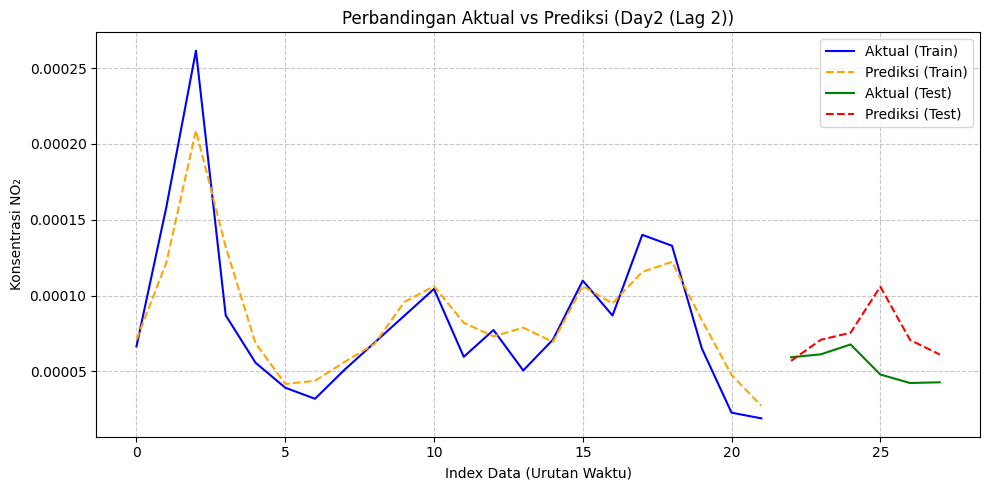

📊 Day3 (Lag 3) [Random Forest Regressor]
MAPE Train: 23.99%
MAPE Test : 50.60%



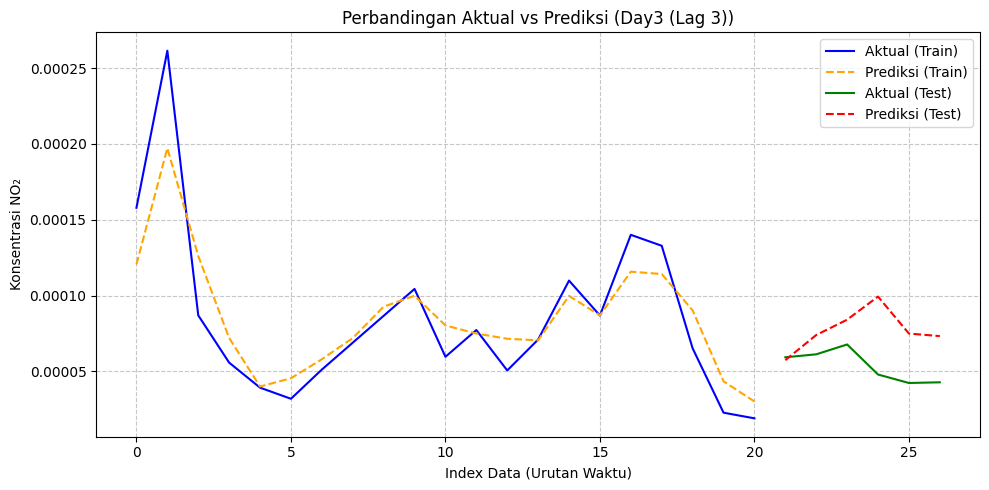

📊 Day4 (Lag 4) [Random Forest Regressor]
MAPE Train: 20.90%
MAPE Test : 51.38%



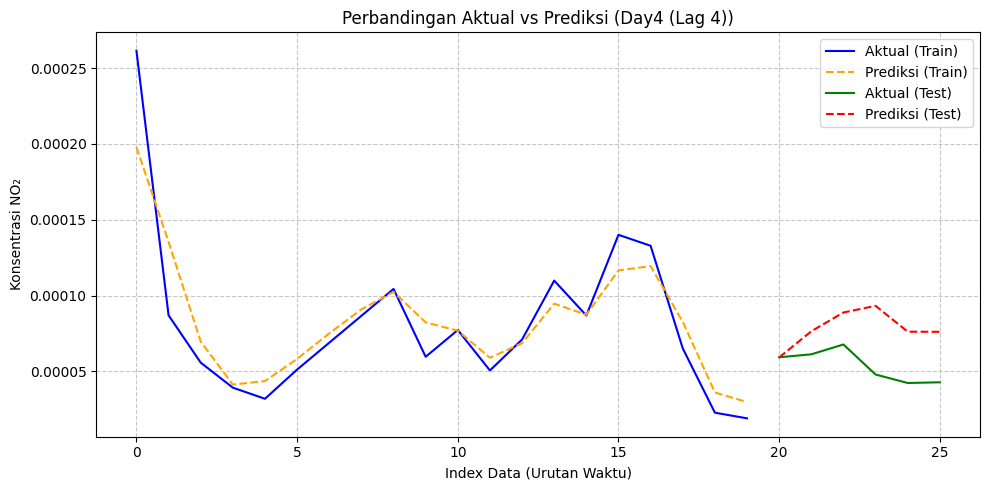

📊 Day5 (Lag 5) [Random Forest Regressor]
MAPE Train: 15.40%
MAPE Test : 66.08%



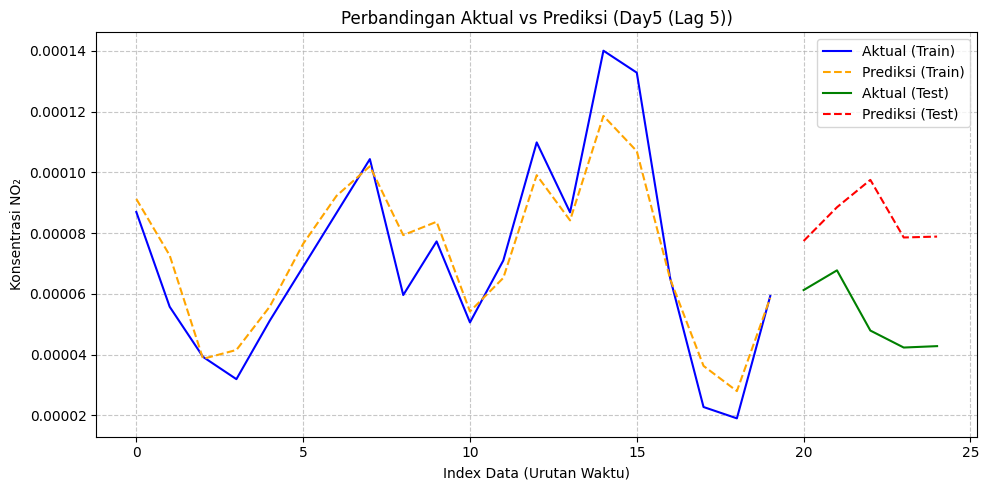


📋 Ringkasan MAPE (Random Forest Regressor):


,MAPE_Train,MAPE_Test
day2,23.284918,43.651070
day3,23.994719,50.598462
day4,20.898504,51.384409
day5,15.402825,66.075051


✅ Model dan Scaler Day5 berhasil disimpan!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# =====================================
# 🔹 Import Library
# =====================================
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from google.colab import files

# =====================================
# 🔹 Fungsi Evaluasi Random Forest Regressor
# =====================================
def evaluate_day_rf(data, n_estimators=300, max_depth=None, train_ratio=0.8, show_plot=True, title=""):
    """
    Evaluasi model Random Forest untuk forecasting time-series
    dengan proses normalisasi berdasarkan data TRAIN saja.
    """
    # --- Pisahkan fitur & target
    X = data.drop(columns=['target'])
    y = data['target']

    # --- Split data time-based (tidak acak)
    split_index = int(len(X) * train_ratio)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    # --- Normalisasi berdasarkan data Train
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # =====================================
    # 🔸 Model Random Forest Regressor
    # =====================================
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train_scaled.ravel())

    # --- Prediksi (dalam skala normalisasi)
    y_train_pred_scaled = rf.predict(X_train_scaled)
    y_test_pred_scaled = rf.predict(X_test_scaled)

    # --- Denormalisasi hasil prediksi
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

    # =====================================
    # 🔹 Evaluasi Akurasi
    # =====================================
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100

    print(f"📊 {title} [Random Forest Regressor]")
    print(f"MAPE Train: {mape_train:.2f}%")
    print(f"MAPE Test : {mape_test:.2f}%\n")

    # =====================================
    # 🔹 Visualisasi Hasil
    # =====================================
    if show_plot:
        plt.figure(figsize=(10, 5))
        # Data Train
        plt.plot(range(len(y_train)), y_train, label="Aktual (Train)", color="blue")
        plt.plot(range(len(y_train)), y_train_pred, label="Prediksi (Train)", color="orange", linestyle="--")
        # Data Test
        plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test, label="Aktual (Test)", color="green")
        plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test_pred, label="Prediksi (Test)", color="red", linestyle="--")

        plt.title(f"Perbandingan Aktual vs Prediksi ({title})")
        plt.xlabel("Index Data (Urutan Waktu)")
        plt.ylabel("Konsentrasi NO₂")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # Return hasil
    return {
        "MAPE_Train": mape_train,
        "MAPE_Test": mape_test,
        "Scaler_X": scaler_X,
        "Scaler_y": scaler_y,
        "Model": rf
    }


# =====================================
# 🔹 Jalankan untuk day2–day5
# =====================================
results = {}
for n, d in zip([2, 3, 4, 5], [day2, day3, day4, day5]):
    results[f"day{n}"] = evaluate_day_rf(d, n_estimators=400, title=f"Day{n} (Lag {n})")

# =====================================
# 🔹 Rekapitulasi MAPE
# =====================================
results_df = pd.DataFrame({
    k: {"MAPE_Train": v["MAPE_Train"], "MAPE_Test": v["MAPE_Test"]}
    for k, v in results.items()
}).T

print("\n📋 Ringkasan MAPE (Random Forest Regressor):")
display(results_df)

# =====================================
# 🔹 Simpan Model dan Scaler Day5 untuk Deploy
# =====================================
model_day5 = results["day5"]["Model"]
scaler_X_day5 = results["day5"]["Scaler_X"]
scaler_y_day5 = results["day5"]["Scaler_y"]

joblib.dump(model_day5, "model_rf_day5.pkl")
joblib.dump(scaler_X_day5, "scalerX_day5.pkl")
joblib.dump(scaler_y_day5, "scalerY_day5.pkl")

print("✅ Model dan Scaler Day5 berhasil disimpan!")

# =====================================
# 🔹 Download otomatis file model & scaler
# =====================================
files.download("model_rf_day5.pkl")
files.download("scalerX_day5.pkl")
files.download("scalerY_day5.pkl")


### **Hasil Grafik**

* Sumbu X (horizontal) menunjukkan jumlah hari sebelumnya (lag) yang digunakan dalam model: 2 hari, 3 hari, 4 hari, dan 5 hari.

* Sumbu Y (vertikal) menunjukkan nilai R² (koefisien determinasi), yaitu ukuran seberapa baik model menjelaskan variasi data aktual.

* Semakin tinggi nilai R² (mendekati 1), semakin baik model dalam memprediksi nilai aktual.

* Nilai R² yang negatif berarti model lebih buruk daripada baseline (rata-rata data), atau dengan kata lain, prediksi model tidak mencerminkan pola data sebenarnya.

## **Evaluasi**

Berdasarkan hasil evaluasi:

* Semua nilai R² berada di sekitar 0 atau negatif, menandakan bahwa model KNN belum mampu menangkap hubungan kuat antara kadar NO₂ hari-hari sebelumnya dengan hari berikutnya.

* Nilai MSE (Mean Squared Error) yang besar dan R² negatif menunjukkan bahwa fluktuasi kadar NO₂ bersifat acak atau dipengaruhi faktor eksternal (seperti cuaca, arah angin, atau aktivitas industri) yang tidak tercermin dalam data historis harian.

* Menambah jumlah lag hari (dari 2 hingga 5) tidak memperbaiki performa model, bahkan memperburuk karena menambah variabel yang tidak relevan untuk dataset kecil.

* Kecenderungan Overfitting

    * Semakin banyak lag (fitur hari sebelumnya) digunakan, akurasi training meningkat, tetapi performa test justru menurun.

    * Ini menandakan model terlalu “hapal” data latih (overfit) dan tidak mampu beradaptasi dengan pola baru.

* MAPE Test tinggi (>40%)

    * Nilai error test yang tinggi (43–66%) menunjukkan model belum cukup baik untuk prediksi jangka waktu berbeda.

    * Kemungkinan disebabkan oleh fluktuasi NO₂ yang tidak stabil atau faktor eksternal (cuaca, lalu lintas) yang tidak dimasukkan ke fitur.

* Performa terbaik relatif

    * Model Day2 (Lag 2) memiliki keseimbangan terbaik antara MAPE Train dan Test.

    * Meskipun error masih tinggi, ini menunjukkan kompleksitas model yang tidak terlalu tinggi sehingga lebih stabil.

## **Deployment**

Deployment akan dilakukan di streamlit. buat beberapa file berikut:


1. app.py
2. requirements.txt
3. masukkan model rf yang sudah di dapatkan dari modelling
4. masukkan file scaler yang sudah didapatkan tadi

#### **App.py**

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import os

# =====================================
# 🌤️ Konfigurasi halaman Streamlit
# =====================================
st.set_page_config(page_title="Prediksi Kualitas Udara (NO₂)", layout="centered")
st.title("🌤️ Prediksi Kualitas Udara (NO₂) - Model Random Forest")
st.markdown("Masukkan data NO₂ beberapa hari sebelumnya untuk memprediksi konsentrasi hari esok.")

# =====================================
# 🧩 Fungsi aman untuk load model & scaler
# =====================================
def safe_load(file_path):
    """Load file pickle secara aman"""
    if not os.path.exists(file_path):
        st.error(f"❌ File `{file_path}` tidak ditemukan di direktori ini.")
        st.stop()
    try:
        return joblib.load(file_path)
    except Exception as e:
        st.error(f"Gagal memuat `{file_path}`: {e}")
        st.stop()

# =====================================
# 📦 Load model dan scaler
# =====================================
model = safe_load("model_rf_day5.pkl")
scaler_X = safe_load("scalerX_day5.pkl")
scaler_y = safe_load("scalerY_day5.pkl")

# =====================================
# 📥 Input manual
# =====================================
st.subheader("🧮 Masukkan Nilai NO₂ Sebelumnya (t-1 s/d t-5)")
t1 = st.number_input("t-1 (hari sebelumnya)", value=0.00005, format="%.8f")
t2 = st.number_input("t-2", value=0.00007, format="%.8f")
t3 = st.number_input("t-3", value=0.00009, format="%.8f")
t4 = st.number_input("t-4", value=0.00006, format="%.8f")
t5 = st.number_input("t-5", value=0.00008, format="%.8f")

# =====================================
# 🔮 Tombol Prediksi
# =====================================
if st.button("🔮 Prediksi Hari Esok"):
    # Buat DataFrame input
    input_data = pd.DataFrame([[t1, t2, t3, t4, t5]], columns=["t1", "t2", "t3", "t4", "t5"])

    # Tambahkan kolom dummy agar cocok dengan scaler_X yang dilatih
    for missing_col in ['feature_index', 'NO2']:
        input_data[missing_col] = 0

    # Urutkan kolom sesuai urutan saat scaler fit
    input_data = input_data[[col for col in scaler_X.feature_names_in_ if col in input_data.columns]]

    # === Normalisasi fitur
    input_scaled = scaler_X.transform(input_data)

    # === Prediksi dalam skala normalisasi
    pred_scaled = model.predict(input_scaled).reshape(-1, 1)

    # === Denormalisasi ke skala asli (pakai scaler_y)
    prediction = scaler_y.inverse_transform(pred_scaled)[0, 0]

    # =====================================
    # 🌍 Konversi ke satuan µg/m³ (WHO)
    # =====================================
    pred_ugm3 = prediction * 2_000_000  # konversi ke µg/m³ (perkiraan)

    if pred_ugm3 <= 40:
        kategori = "Sangat Baik ✅"
        warna = "🟢"
    elif pred_ugm3 <= 100:
        kategori = "Baik 😊"
        warna = "🟢"
    elif pred_ugm3 <= 200:
        kategori = "Sedang ⚠️"
        warna = "🟡"
    elif pred_ugm3 <= 400:
        kategori = "Buruk 🚨"
        warna = "🟠"
    else:
        kategori = "Sangat Buruk ☠️"
        warna = "🔴"

    # =====================================
    # 📊 Tampilkan hasil
    # =====================================
    st.success(f"🌱 Prediksi Konsentrasi NO₂ Hari Esok: **{prediction:.8f}** (≈ {pred_ugm3:.2f} µg/m³)")
    st.info(f"**Kategori Udara (WHO): {kategori} {warna}**")
    st.caption("📘 Berdasarkan WHO Air Quality Guidelines 2021 (NO₂ ≤ 200 µg/m³ untuk 1 jam).")

    # =====================================
    # 📈 Visualisasi mini
    # =====================================
    st.subheader("📈 Grafik Prediksi")
    df_plot = pd.DataFrame({
        "Hari": ["t-5", "t-4", "t-3", "t-2", "t-1", "Prediksi (t)"],
        "NO₂ (Relatif)": [t5, t4, t3, t2, t1, prediction]
    })
    st.line_chart(df_plot.set_index("Hari"))

# =====================================
# 🧾 Catatan Footer
# =====================================
st.markdown("---")
st.caption("🚀 Dibuat oleh Yudha Caesar Maulana • Model Random Forest Regressor dengan normalisasi MinMax berdasarkan data historis NO₂ harian.")


#### **Requrements.txt**



In [ ]:
streamlit
pandas
numpy
scikit-learn
joblib

### Jalankan Deployment

Saya membuat repo baru yang dapat anda akses di: https://github.com/yudhacm/forecasting-no2

kemudian masuk ke streamlit dan hubungkan dengan github anda dan pilih main file di app.py


setelah itu tentukan link url

dan hasil deployment saya dapat dilihat di link berikut:

https://forecasting-no2-230411100057.streamlit.app/

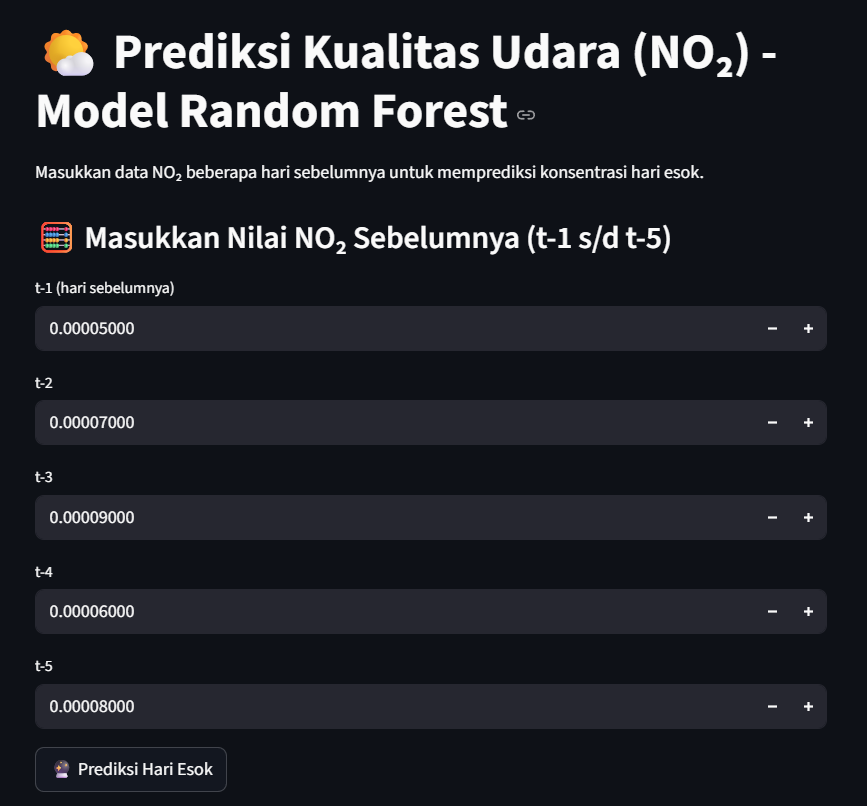

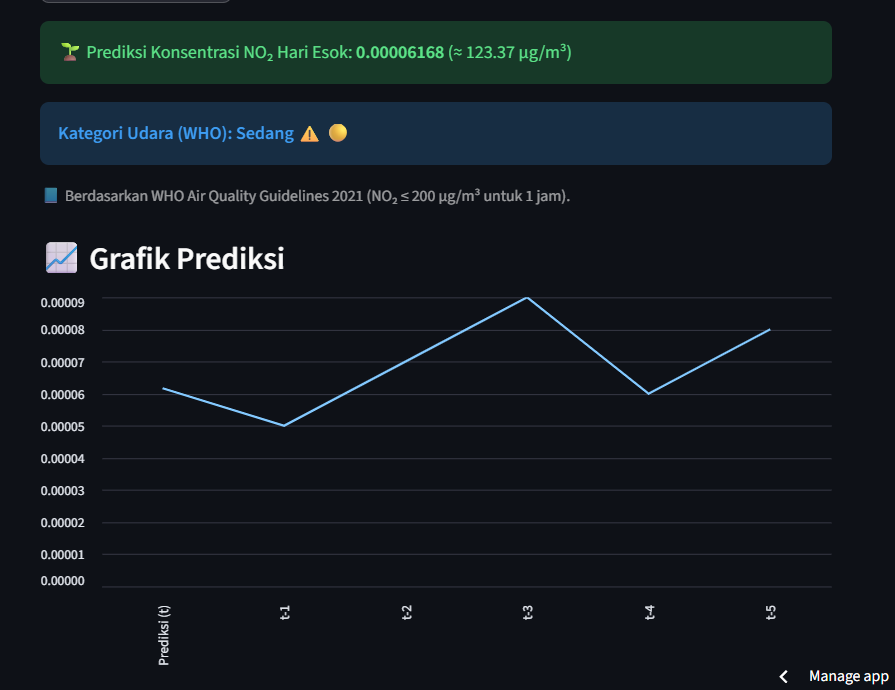